In [2]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Load and normalize CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [5]:
class IMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='Zipf-Mandelbrot', imb_factor=2.3, imb_factor2=54.7, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor, imb_factor2)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor, imb_factor2):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        if imb_type == 'Zipf-Mandelbrot':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx+imb_factor2)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx+imb_factor2)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        if imb_type == 'Zipf':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

In [6]:
class IMBALANCECIFAR100(IMBALANCECIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }
    cls_num = 100

In [7]:
Liste = [500, 296, 189, 131, 96, 372, 209, 134, 93, 68, 270, 152, 97, 67, 49, 200, 113, 72, 50, 36, 152, 85, 54, 38, 28, 117, 66, 42, 29, 21, 92, 51, 33, 23, 16, 73, 41, 26, 18, 13, 59, 33, 21, 14, 10, 48, 27, 17, 12, 8, 39, 22, 14, 9, 7, 32, 18, 11, 8, 6, 27, 15, 9, 6, 5, 23, 13, 8, 5, 4, 19, 11, 7, 4, 3, 16, 9, 6, 4, 3, 14, 8, 5, 3, 2, 12, 7, 4, 3, 2, 10, 6, 3, 2, 2, 9, 5, 3, 2, 1]

In [104]:
Liste2 = Liste.copy()
Liste2.sort(reverse=True)
print(Liste2)

[500, 372, 296, 270, 209, 200, 189, 152, 152, 134, 131, 117, 113, 97, 96, 93, 92, 85, 73, 72, 68, 67, 66, 59, 54, 51, 50, 49, 48, 42, 41, 39, 38, 36, 33, 33, 32, 29, 28, 27, 27, 26, 23, 23, 22, 21, 21, 19, 18, 18, 17, 16, 16, 15, 14, 14, 14, 13, 13, 12, 12, 11, 11, 10, 10, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1]


In [108]:
class GoodIMBALANCECIFAR10(torchvision.datasets.CIFAR10):
    cls_num = 10

    def __init__(self, root, imb_type='Good', imb_factor=2.3, imb_factor2=54.7, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(GoodIMBALANCECIFAR10, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, imb_factor, imb_factor2)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, imb_factor, imb_factor2):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        if imb_type == 'Good':
            for cls_idx in range(cls_num):
                num = Liste2[cls_idx]
                img_num_per_cls.append(int(num))
        if imb_type == 'Zipf-Mandelbrot':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx+imb_factor2)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx+imb_factor2)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        if imb_type == 'Zipf':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

In [109]:
class GoodIMBALANCECIFAR100(GoodIMBALANCECIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }
    cls_num = 100

In [70]:
class CIFAR100Nils(torchvision.datasets.CIFAR100):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CIFAR100Nils, self).__init__(root, train, transform, target_transform, download)

        # update labels
        coarse_labels = np.array([ 20,  5, 70,  40,  0,  30,  35,  36, 90,  15,
                                   16, 71,  45, 91, 37, 55,  17,  46,  38, 56,
                                   31, 57,  25, 50,  39,  32, 65, 75,  18, 76, 
                                   1, 58,  6, 51, 60, 72, 80, 47, 59, 26,
                                   27, 95,  41,  42, 77, 66, 73, 85, 92, 52,
                                   81, 21, 86,  22,  10,  2, 87,  23, 93, 88,
                                   53, 19,  11, 61, 62, 82, 63,  7,  48, 96, 
                                   12, 54,  3,  8, 83, 64,  49, 67, 78, 68,
                                  84, 97,  13,  24,  33, 98,  28,  29,  43, 99,
                                  94,  9,  14, 79,  34,  4, 89,  44, 74, 69])
        self.targets = coarse_labels[self.targets]

        # update classes
        self.classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale',
                        'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout',
                        'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
                        'bottle', 'bowl', 'can', 'cup', 'plate',
                        'apple', 'mushroom', 'orange', 'pear', 'sweet_pepper',
                        'clock', 'keyboard', 'lamp', 'telephone', 'television',
                        'bed', 'chair', 'couch', 'table', 'wardrobe',
                        'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
                        'bear', 'leopard', 'lion', 'tiger', 'wolf',
                        'bridge', 'castle', 'house', 'road', 'skyscraper',
                        'cloud', 'forest', 'mountain', 'plain', 'sea',
                        'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
                        'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
                        'crab', 'lobster', 'snail', 'spider', 'worm',
                        'baby', 'boy', 'girl', 'man', 'woman',
                        'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
                        'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
                        'maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree',
                        'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train',
                        'lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']

In [71]:
class IMBALANCECIFAR100Realist(CIFAR100Nils):
    cls_num = 100

    def __init__(self, root, imb_type='ZM', a1=4, q1=10, a2 = 2, q2=2, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR100Realist, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, a1, q1, a2, q2)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, a1, q1, a2, q2):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        if imb_type == 'ZM':
            Normalisation = 0
            for i in range(1, 21): #Les genres
                Int = []
                for j in range(1, 6): #les especes
                    Normalisation += (1/(i+q1)**(a1))*(1/(j+q2)**(a2))
            for cls_idx in range(cls_num):
                cls_genre = cls_idx % 5 + 1
                cls_espece = cls_idx // 5 + 1
                num = (1/(cls_espece+q1)**(a1))*(1/(cls_genre+q2)**(a2))
                img_num_per_cls.append(min(int(num*5000/Normalisation), 500))
        if imb_type == 'Zipf-Mandelbrot':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx+imb_factor2)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx+imb_factor2)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        if imb_type == 'Zipf':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

In [158]:
Liste3 = [68,200, 8, 27, 500, 41, 33, 32, 3, 93, 92, 8, 21, 3, 29, 14, 85, 21, 28, 14, 39, 13, 51, 17, 27, 38, 9, 7, 73, 6, 372, 13, 189, 16, 12, 8, 5, 19, 12, 50, 49, 2, 26, 23, 6, 9, 7,
 4, 3, 16, 5, 67, 4, 66, 131, 296, 4, 59, 3, 3, 15, 72, 117, 11, 11, 5, 10, 152, 18, 2, 113, 14, 270, 152, 5, 10, 18, 9, 6, 9, 4, 2, 97, 54, 36, 2, 48, 42, 23, 1, 2, 134, 96, 6, 33, 209, 3,
 22, 7, 8]

In [159]:
#Dataset_Generas
class IMBALANCECIFAR100Generas(torchvision.datasets.CIFAR100):
    cls_num = 100

    def __init__(self, root, imb_type='Generas', a1=4, q1=10, a2 = 2, q2=2, rand_number=0, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super(IMBALANCECIFAR100Generas, self).__init__(root, train, transform, target_transform, download)
        np.random.seed(rand_number)
        img_num_list = self.get_img_num_per_cls(self.cls_num, imb_type, a1, q1, a2, q2)
        self.gen_imbalanced_data(img_num_list)

    def get_img_num_per_cls(self, cls_num, imb_type, a1, q1, a2, q2):
        img_max = len(self.data) / cls_num
        img_num_per_cls = []
        if imb_type == 'exp':
            for cls_idx in range(cls_num):
                num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
                img_num_per_cls.append(int(num))
        if imb_type == 'Generas':
            for cls_idx in range(cls_num):
                num = Liste3[cls_idx]
                img_num_per_cls.append(int(num))
        if imb_type == 'ZM':
            Normalisation = 0
            for i in range(1, 21): #Les genres
                Int = []
                for j in range(1, 6): #les especes
                    Normalisation += (1/(i+q1)**(a1))*(1/(j+q2)**(a2))
            for cls_idx in range(cls_num):
                cls_genre = cls_idx % 5 + 1
                cls_espece = cls_idx // 5 + 1
                num = (1/(cls_espece+q1)**(a1))*(1/(cls_genre+q2)**(a2))
                img_num_per_cls.append(min(int(num*5000/Normalisation), 500))
        if imb_type == 'Zipf-Mandelbrot':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx+imb_factor2)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx+imb_factor2)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        if imb_type == 'Zipf':
            invC = 0
            for cls_idx in range(1, cls_num+1):
                invC += 1/((cls_idx)**(imb_factor))
            for cls_idx in range(1, cls_num+1):
                num = img_max * (1/((cls_idx)**(imb_factor)*invC))
                img_num_per_cls.append(int(num))
        elif imb_type == 'step':
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max))
            for cls_idx in range(cls_num // 2):
                img_num_per_cls.append(int(img_max * imb_factor))
        else:
            img_num_per_cls.extend([int(img_max)] * cls_num)
        return img_num_per_cls

    def gen_imbalanced_data(self, img_num_per_cls):
        new_data = []
        new_targets = []
        targets_np = np.array(self.targets, dtype=np.int64)
        classes = np.unique(targets_np)
        # np.random.shuffle(classes)
        self.num_per_cls_dict = dict()
        for the_class, the_img_num in zip(classes, img_num_per_cls):
            self.num_per_cls_dict[the_class] = the_img_num
            idx = np.where(targets_np == the_class)[0]
            np.random.shuffle(idx)
            selec_idx = idx[:the_img_num]
            new_data.append(self.data[selec_idx, ...])
            new_targets.extend([the_class, ] * the_img_num)
        new_data = np.vstack(new_data)
        self.data = new_data
        self.targets = new_targets
        
    def get_cls_num_list(self):
        cls_num_list = []
        for i in range(self.cls_num):
            cls_num_list.append(self.num_per_cls_dict[i])
        return cls_num_list

In [160]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = IMBALANCECIFAR100Generas(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle',
 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl',
 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower','leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree',
 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger',
 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')

Files already downloaded and verified
Files already downloaded and verified


In [162]:
print(len(trainset))
print(len(testset))

4927
10000


Let us show some of the training images, for fun.



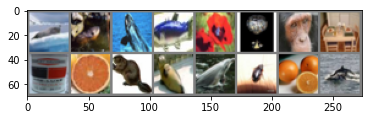

seal  beaver whale trout poppy cup   chimpanzee table can   orange beaver seal  dolphin cockroach orange dolphin


In [163]:
from torch.cuda import device_count
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

# show images
imshow(torchvision.utils.make_grid(images.cpu()))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [181]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#net = Net()
net = torchvision.models.resnet18()
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [191]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [192]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.5f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.00050
[1,   100] loss: 0.00048
[1,   150] loss: 0.00040
[1,   200] loss: 0.00018
[1,   250] loss: 0.00027
[1,   300] loss: 0.00077
[2,    50] loss: 0.00033
[2,   100] loss: 0.00041
[2,   150] loss: 0.00019
[2,   200] loss: 0.00029
[2,   250] loss: 0.00028
[2,   300] loss: 0.00022
[3,    50] loss: 0.00018
[3,   100] loss: 0.00047
[3,   150] loss: 0.00025
[3,   200] loss: 0.00025
[3,   250] loss: 0.00028
[3,   300] loss: 0.00032
[4,    50] loss: 0.00027
[4,   100] loss: 0.00032
[4,   150] loss: 0.00034
[4,   200] loss: 0.00024
[4,   250] loss: 0.00037
[4,   300] loss: 0.00029
[5,    50] loss: 0.00019
[5,   100] loss: 0.00035
[5,   150] loss: 0.00025
[5,   200] loss: 0.00024
[5,   250] loss: 0.00016
[5,   300] loss: 0.00030
[6,    50] loss: 0.00025
[6,   100] loss: 0.00020
[6,   150] loss: 0.00014
[6,   200] loss: 0.00027
[6,   250] loss: 0.00023
[6,   300] loss: 0.00023
[7,    50] loss: 0.00027
[7,   100] loss: 0.00018
[7,   150] loss: 0.00016
[7,   200] loss: 0.00023


Let's quickly save our trained model:



In [193]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



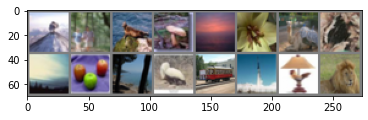

GroundTruth:  mountain forest seal  mushroom


In [194]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [196]:
net = torchvision.models.resnet18()
#net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:



In [197]:
outputs = net(images).to(device)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [198]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dolphin mouse sunflower orchid


The results are not great.

Let us look at how the network performs on the whole dataset.



In [199]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images).to(device)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total:.3f} %')

Accuracy of the network on the test images: 12.000 %


That looks way better than chance, which is 1% accuracy (randomly picking
a class out of 100 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [133]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images).to(device)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] != 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f' {classname:5s} is {total_pred[classname]:.1f}')

Accuracy for class: apple is 76.0 %
Accuracy for class: aquarium_fish is 63.0 %
Accuracy for class: baby  is 34.0 %
Accuracy for class: bear  is 29.0 %
Accuracy for class: beaver is 24.0 %
Accuracy for class: bed   is 35.0 %
Accuracy for class: bee   is 34.0 %
Accuracy for class: beetle is 27.0 %
Accuracy for class: bicycle is 33.0 %
Accuracy for class: bottle is 36.0 %
Accuracy for class: bowl  is 14.0 %
Accuracy for class: boy   is 10.0 %
Accuracy for class: bridge is 29.0 %
Accuracy for class: bus   is 22.0 %
Accuracy for class: butterfly is 15.0 %
Accuracy for class: camel is 10.0 %
Accuracy for class: can   is 20.0 %
Accuracy for class: castle is 40.0 %
Accuracy for class: caterpillar is 28.0 %
Accuracy for class: cattle is 12.0 %
Accuracy for class: chair is 26.0 %
Accuracy for class: chimpanzee is 16.0 %
Accuracy for class: clock is 18.0 %
Accuracy for class: cloud is 29.0 %
Accuracy for class: cockroach is 38.0 %
Accuracy for class: couch is 11.0 %
Accuracy for class: crab  is 

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




In [ ]:
    inputs, labels = data[0].to(device), data[1].to(device)
